# Community alignment of training questions

In [ ]:
import matplotlib.pyplot as plt
from load_forecasted_open_questions import load_forecasted_open_questions
from community_forecast import *
import glob
from extract_forecast import *
import forecasting_tools
from flatten_dict import flatten_dict
import pandas as pd
from prompt_question import prompt_question
from datetime import datetime
from RAGForecaster import RAGForecaster
from EnhancedResearchPro import EnhancedResearchPro
from extract_forecast import extract_forecast
from error import error
from tqdm import tqdm
tqdm.pandas()
pd.set_option('display.max_columns', None)

def predict(dfn, question, iterations = 3):
    ffn = f'{dfn}/{question.id_of_question}.md'
    with open(ffn, 'r') as f:
        return f.read()

def load_research(row):
    with open(f"research/{row['id']}.md", 'r') as f:
        return f.read()

def pull_asknews(row):
    fn = f'asknews/{row.id}.md'
    with open(fn, 'r') as f:
        return f.read()

In [9]:
def extract_only_forecast(id_to_question, forecasts, id):
    question = id_to_question[id]
    question_type = type(question)
    forecast = forecasts[id]
    if question_type == forecasting_tools.data_models.questions.BinaryQuestion:
        prediction = extract_probability_from_response_as_percentage_not_decimal(forecast)/100.0
    elif question_type == forecasting_tools.data_models.questions.MultipleChoiceQuestion:
        options = question.options
        option_probabilities = extract_option_probabilities_from_response(forecast, options)
        prediction = generate_multiple_choice_forecast(options, option_probabilities)
    elif question_type == forecasting_tools.data_models.questions.NumericQuestion:
        prediction = extract_percentiles_from_response(forecast)
    return prediction

In [12]:
def community_alignment(model = 'llama3'):
    num_questions = (0,100000)
    questions = load_forecasted_open_questions(num_questions, model)
    id_to_forecast = {question.api_json['id']: community_forecast(question) for question in questions}
    id_to_question = {question.api_json['id']: question for question in questions}
    pdir = f'forecast_{model}'
    fns = glob.glob(f'{pdir}/*.md')
    ids = [int(fn.split('/')[1].split('.')[0]) for fn in fns]
    forecasts = {id: open(f'{pdir}/{id}.md').read() for id in ids}
    community_ids = list(id_to_forecast.keys())
    forecast_ids = list(forecasts.keys())
    done = list(set(forecast_ids).intersection(community_ids))
    for id in done:
        #print(id)
        foo = extract_only_forecast(id_to_question, forecasts, id)
    
    predictions = {id: extract_only_forecast(id_to_question, forecasts, id) for id in done}
    q_done = [id_to_question[id] for id in done]
    qflat = [flatten_dict(q.api_json, sep='_') for q in q_done]
    df = pd.DataFrame(qflat)
    df['crowd'] = df.apply(lambda row: id_to_forecast[row.id], axis=1)
    df['question_options'] = df['question_options'].apply(repr)
    df = df[['id',
             'open_time',
             'scheduled_resolve_time',
             'title',
             'question_description',
             'question_resolution_criteria',
             'question_fine_print',
             'question_type',
             'question_options',
             'question_group_variable',
             'question_question_weight',
             'question_unit',
             'question_open_upper_bound',
             'question_open_lower_bound',
             'question_scaling_range_max',
             'question_scaling_range_min',
             'question_scaling_zero_point',
             'crowd']]
    dfn = f'forecast_{model}'
    df['today'] = datetime.now().strftime("%Y-%m-%d")
    df['asknews'] = df.apply(pull_asknews, axis=1)
    df['research'] = df.apply(load_research, axis=1)
    rag = RAGForecaster()
    research_bot = EnhancedResearchPro(rag)
    df['id_of_question'] = df['id']
    research_bot.process_dataframe(df, use_cutoff=False)
    rag.research_bot = research_bot
    # Updated learning field with raw text extraction
    df['learning'] = df.apply(
        lambda row: [
            m['raw_text'] 
            for m, _ in research_bot.retrieval_cache.get(row['title'], []) 
            if 'raw_text' in m  # Safety check for legacy entries
        ], 
        axis=1
    )
    df['prompt'] = df.apply(prompt_question, axis=1)
    df['forecast'] = df.progress_apply(lambda question: predict(dfn, question), axis=1)
    df['prediction'] = df.apply(extract_forecast, axis=1)
    df = df[~df.crowd.apply(lambda x: x is None)].copy()
    df['error'] = df.apply(error, axis=1)
    plt.hist(df.error.values, bins=20);
    fn = f'community_{model}.json'
    df.to_json(fn, indent=4)
    print('saved', fn)
    return df

Loaded existing index from forecast_index.faiss
Index contains 4767 vectors at initialization


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 711/711 [00:00<00:00, 33001.53it/s]


saved community_llama3.json


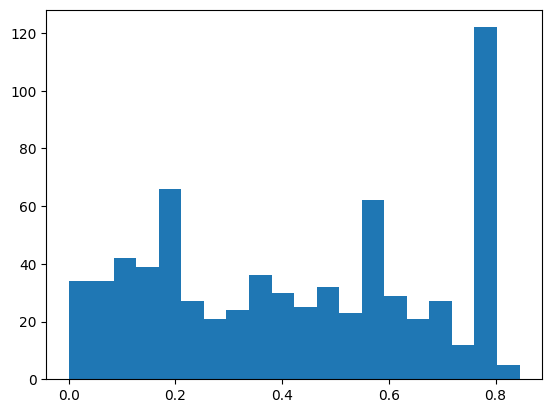

In [15]:
df = community_alignment('llama3')

Loaded existing index from forecast_index.faiss
Index contains 4767 vectors at initialization


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 711/711 [00:00<00:00, 31548.80it/s]


saved community_perplexity.json


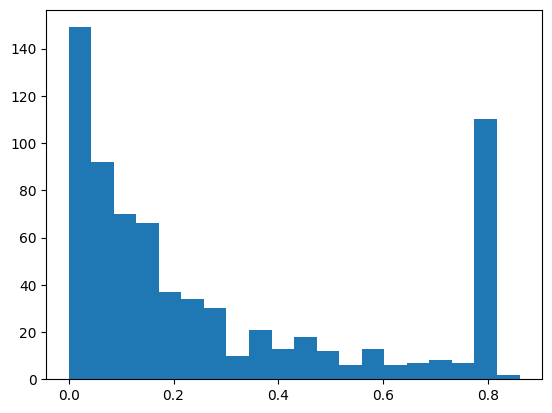

In [16]:
dfp = community_alignment('perplexity')

In [19]:
df1 = df[['id', 'title', 'error']].sort_values(by='error')

In [21]:
df2 = dfp[['id', 'title', 'error']].sort_values(by='error')

In [42]:
n=32
hards = list(set(df1.iloc[-n:].id.values).intersection(df2.iloc[-n:].id.values))
hards

[7811, 8734, 6633, 1482, 3054, 1454, 6614, 1337, 5531, 2622]

In [54]:
dferr1 = df1[df1.id.isin(hards)]

In [55]:
dferr2 = df2[df2.id.isin(hards)]

In [57]:
# First, rename the 'error' columns in each DataFrame
dferr1_renamed = dferr1.rename(columns={'error': 'error1'})
dferr2_renamed = dferr2.rename(columns={'error': 'error2'})

# Now merge on 'id' and 'title'
dferr = pd.merge(
    dferr1_renamed[['id', 'title', 'error1']],
    dferr2_renamed[['id', 'title', 'error2']],
    on=['id', 'title'],
    how='inner'  # or 'outer'/'left'/'right' as needed
)

In [58]:
dferr

,id,title,error1,error2
0,6614,What is the highest value 1 bitcoin will ever ...,0.8,0.8
1,1482,What percentage of Americans will be obese or ...,0.8,0.8
2,1337,Drake's Equation 1st Parameter R∗: What is the...,0.8,0.8
3,7811,How many nuclear weapons will be detonated off...,0.8,0.8
4,8734,What percentage of new vehicle production will...,0.8,0.8
5,5531,How many seats will be on the Supreme Court of...,0.8,0.8
6,1454,What will be the total aggregate score given t...,0.8,0.8
7,6633,In how many years will humanity's descendants ...,0.8,0.8
8,2622,What will be the highest level of annual GDP g...,0.8,0.8
9,3054,How many hours will the average American emplo...,0.8,0.8


In [63]:
hard_ids = dferr.id.values

In [64]:
hard_ids

array([6614, 1482, 1337, 7811, 8734, 5531, 1454, 6633, 2622, 3054])

In [1]:
hard_ids

NameError: name 'hard_ids' is not defined